# Typicality-based Sampling from INN

In [1]:
import torch
import numpy as np
import torchvision
from torchvision import datasets, transforms

from pathlib import Path

import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy import signal

from tqdm.notebook import tqdm
import config
from models import INN

from IPython.display import set_matplotlib_formats, display_markdown

c = config.Config()

device = 'cuda' if torch.cuda.is_available() else 'cpu'

np.set_printoptions(threshold=np.inf)


def free_cuda_tensors():
    for k in list(locals().keys()):
        if type(eval(k)) == torch.Tensor:
            if eval(k).is_cuda:
                if k not in ['fixed_targets', 'mean', 'cov', 'icov', 'w', 'v']:
                    exec(f'del {k}')
                    print(k)
    torch.cuda.ipc_collect()
    torch.cuda.empty_cache()


def tensor2imgs(t, nrow=10):
    imgrid = torchvision.utils.make_grid(t, nrow, pad_value=1)
    return imgrid.data.mul(255).clamp(0, 255).byte().cpu().numpy()


def make_cond(labels):
    cond_tensor = torch.zeros(labels.size(0), c.ncl).cuda()
    if c.conditional:
        cond_tensor.scatter_(1, labels.view(-1, 1), 1.)
    else:
        cond_tensor[:, 0] = 1
    return cond_tensor


def b(log_n):
    if type(log_n) is not torch.Tensor:
        log_n = torch.tensor(log_n, device=device, dtype=torch.float)

    return torch.sqrt(2 * log_n) - (torch.log(log_n) + torch.log(4 * torch.tensor(np.pi)))/(2 * torch.sqrt(2 * log_n))


def a(log_n):
    if type(log_n) is not torch.Tensor:
        log_n = torch.tensor(log_n, device=device, dtype=torch.float)

    return torch.sqrt(2 * log_n)


fixed_targets = torch.tensor(list(range(c.ncl)),
                             device=device).repeat_interleave(c.ncl)

## Calculate Latent Representation of Training Set

In [2]:
train_loader = torch.utils.data.DataLoader(
    datasets.EMNIST('./data', split='digits', train=True, download=True,
                    transform=transforms.Compose([
#                         transforms.Pad(2),
                        transforms.ToTensor(),
                        transforms.Normalize((0.5,), (0.5,)),
                        transforms.Lambda(lambda x: x.permute(0, 2, 1)),
#                         transforms.Lambda(lambda x: x.repeat(c.nch, 1, 1)),
                    ])),
    batch_size=c.batch_size, shuffle=True, pin_memory=True, num_workers=4,
    drop_last=True
)
test_loader = torch.utils.data.DataLoader(
    datasets.EMNIST('./data', split='digits', train=False, download=True,
                    transform=transforms.Compose([
#                         transforms.Pad(2),
                        transforms.ToTensor(),
                        transforms.Normalize((0.5,), (0.5,)),
                        transforms.Lambda(lambda x: x.permute(0, 2, 1)),
#                         transforms.Lambda(lambda x: x.repeat(c.nch, 1, 1)),
                    ])),
    batch_size=c.batch_size, shuffle=True, pin_memory=True, num_workers=4,
    drop_last=True
)

In [3]:
train_loader = torch.utils.data.DataLoader(
    datasets.FakeData(size=240000, image_size=(1, 32, 32),
                      transform=transforms.Compose([
                          transforms.ToTensor(),
                      ])),
    batch_size=c.batch_size, shuffle=True, pin_memory=True, num_workers=4,
    drop_last=True
)

In [6]:
c.couplig_type = 'GLOW'
model = INN().to(device)

# 500 epochs
# model.load_state_dict(torch.load('runs/Jan21_00-34-42_GLaDOS/checkpoints/generator_in.pt'))

# 1200 epochs
# model.load_state_dict(torch.load('runs/Feb06_14-23-13_GLaDOS/checkpoints/generator_in.pt'))
model.load_state_dict(dict(filter(lambda x: 'tmp' not in x[0], torch.load('runs/Feb27_13-53-14_GLaDOS/checkpoints/generator_in.pt').items())))


model = model.eval()

Node 'downsample1' takes the following inputs:
	 Output #0 of node 'input' with dims (1, 28, 28)

Node 'coupling_conv1_0' takes the following inputs:
	 Output #0 of node 'downsample1' with dims (4, 14, 14)

Node 'permute_conv1_0' takes the following inputs:
	 Output #0 of node 'coupling_conv1_0' with dims (4, 14, 14)

Node 'coupling_conv1_1' takes the following inputs:
	 Output #0 of node 'permute_conv1_0' with dims (4, 14, 14)

Node 'permute_conv1_1' takes the following inputs:
	 Output #0 of node 'coupling_conv1_1' with dims (4, 14, 14)

Node 'coupling_conv1_2' takes the following inputs:
	 Output #0 of node 'permute_conv1_1' with dims (4, 14, 14)

Node 'permute_conv1_2' takes the following inputs:
	 Output #0 of node 'coupling_conv1_2' with dims (4, 14, 14)

Node 'coupling_conv1_3' takes the following inputs:
	 Output #0 of node 'permute_conv1_2' with dims (4, 14, 14)

Node 'permute_conv1_3' takes the following inputs:
	 Output #0 of node 'coupling_conv1_3' with dims (4, 14, 14)

No

In [4]:
classifier = torch.load('checkpoints/classifier_mnist.pth')
classifier = classifier.eval()

/home/tillb/miniconda3/envs/pytorch-latest/lib/python3.7/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'models.Classifier' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [8]:
out_pos = torch.empty(0, 28 * 28)
classes = torch.empty(0).long()
with torch.no_grad():
    for x, y in tqdm(train_loader):
        x = x.to(device)
        y = y.to(device)
        output = model(x, make_cond(y))
        out_pos = torch.cat([out_pos, output.data.cpu()])
        classes = torch.cat([classes, y.data.cpu()])

In [9]:
with torch.no_grad():
    mean = out_pos.mean(dim=0).to(device)
    cov = torch.tensor(np.cov(out_pos.cpu().numpy().T), device=device, dtype=torch.float)
    icov = torch.inverse(cov)
    w, v = torch.eig(cov, eigenvectors=True)

## Investigate Training Set Statistics

### Covariance Matrix

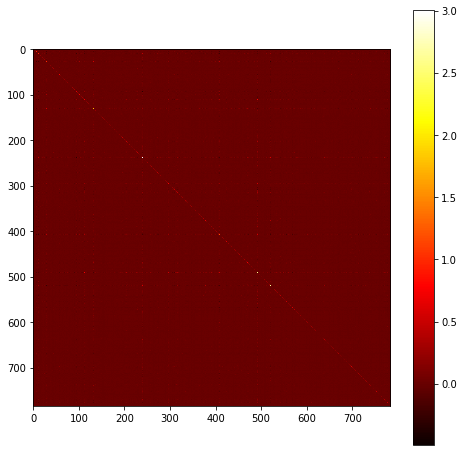

In [10]:
plt.figure(figsize=(8,8))
plt.imshow(cov.cpu(), cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

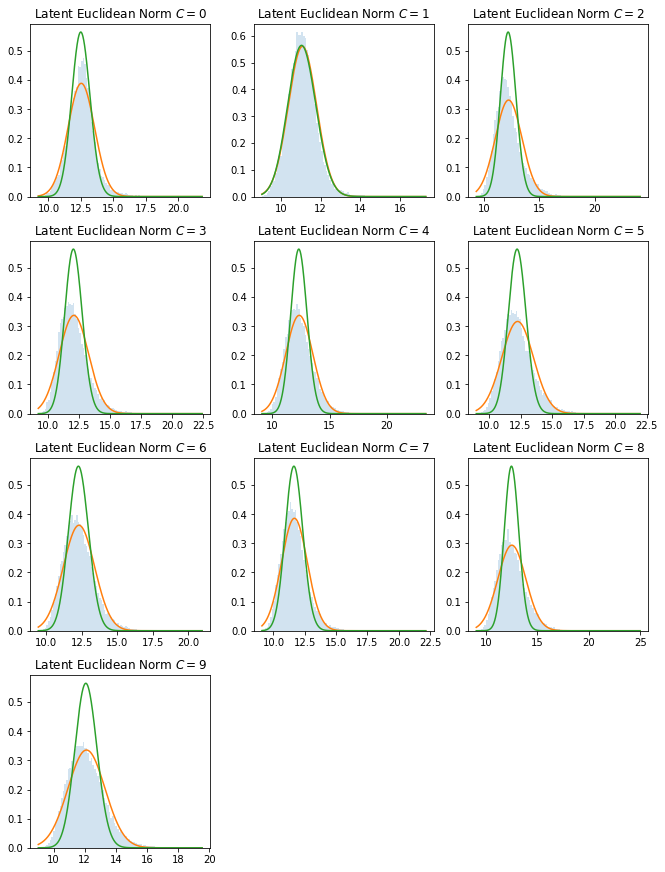

In [11]:
def per_class_euclidean():
    with torch.no_grad():
        fig, axes = plt.subplots(4, 3, figsize=(9, 12), constrained_layout=True)

        axes = axes.flatten()

        for i in tqdm(range(10)):
            dc = torch.norm(out_pos[classes == i], dim=1)
            axes[i].hist(dc, bins=100, density=True,
                     alpha=0.2)

            x = np.linspace(dc.min(), dc.max(), 1000)
            axes[i].plot(x, stats.norm.pdf(x, dc.mean(), dc.std()), label='Normal Distribution')
            axes[i].plot(x, stats.chi.pdf(x, dc.mean()**2), label='$\chi$-Distribution')
            axes[i].set_title(f'Latent Euclidean Norm $C={i}$')

        fig.delaxes(axes[10])
        fig.delaxes(axes[11])

        plt.show()
    
per_class_euclidean()

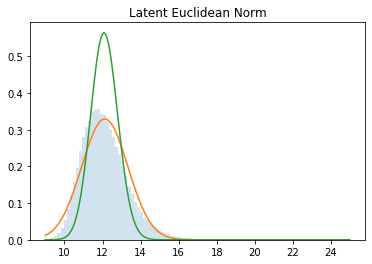

In [12]:
def training_set_latent_norm():
    with torch.no_grad():
        dc = torch.norm(out_pos, dim=1)
        plt.hist(dc, bins=100, density=True,
                 alpha=0.2)

        x = np.linspace(dc.min(), dc.max(), 1000)
        plt.plot(x, stats.norm.pdf(x, dc.mean(), dc.std()), label='Normal Distribution')
        plt.plot(x, stats.chi.pdf(x, dc.mean()**2), label='$\chi$-Distribution')
        plt.title(f'Latent Euclidean Norm')
        plt.show()

training_set_latent_norm()

Class 0: 771
Class 1: 604
Class 2: 784
Class 3: 782
Class 4: 780
Class 5: 779
Class 6: 768
Class 7: 758
Class 8: 780
Class 9: 756



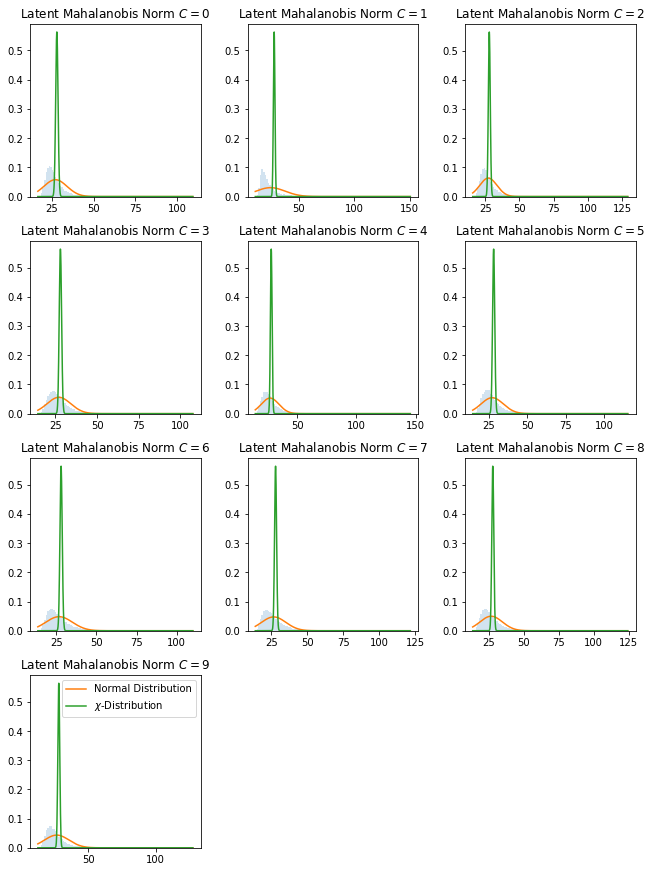

In [14]:
def per_class_mahalanobis():
    with torch.no_grad():
        fig, axes = plt.subplots(4, 3, figsize=(9, 12), constrained_layout=True)

        axes = axes.flatten()

        for i in tqdm(range(10)):
            op = out_pos[classes == i].to(device)
            m = op.mean(dim=0).to(device)
            cv = torch.tensor(np.cov(op.cpu().numpy().T), device=device, dtype=torch.float)
            icv = torch.inverse(cv)
            print(f"Class {i}: {np.linalg.matrix_rank(cv.cpu().numpy())}")
            dc = torch.sqrt((op - m)[:, None, :] @ icv @
                                 (op - m)[:, :, None]).reshape(-1).cpu()
            axes[i].hist(dc, bins=100, density=True,
                     alpha=0.2)

            x = np.linspace(dc.min(), dc.max(), 1000)
            axes[i].plot(x, stats.norm.pdf(x, dc.mean(), dc.std()), label='Normal Distribution')
            axes[i].plot(x, stats.chi.pdf(x, 28*28), label='$\chi$-Distribution')
            axes[i].set_title(f'Latent Mahalanobis Norm $C={i}$')

        fig.delaxes(axes[10])
        fig.delaxes(axes[11])

        plt.legend()
        plt.show()
    
per_class_mahalanobis()

100%|██████████| 10/10 [00:01<00:00,  5.52it/s]


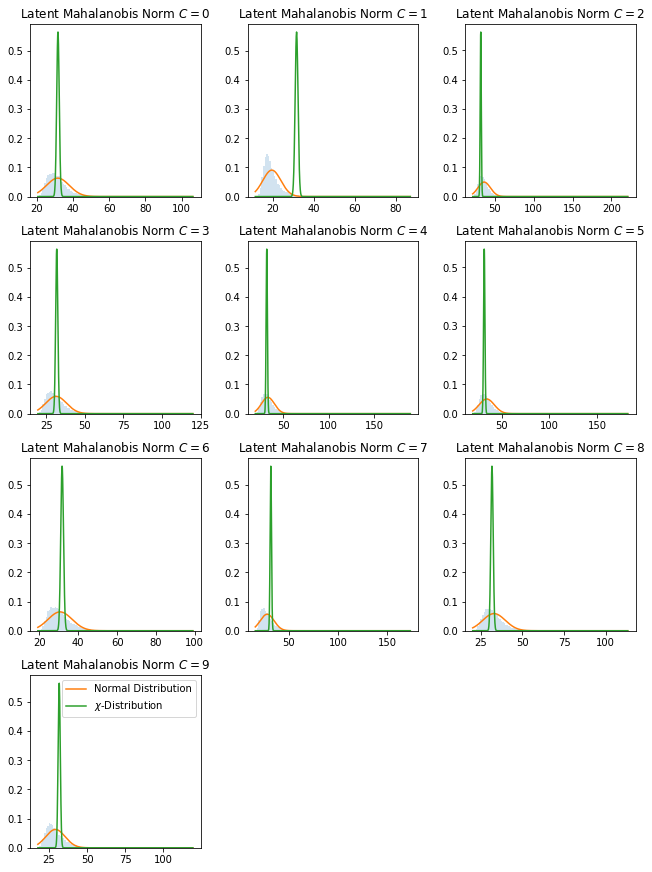

In [11]:
def marginalized_per_class_mahalanobis(d1, d2):
    with torch.no_grad():
        fig, axes = plt.subplots(4, 3, figsize=(9, 12), constrained_layout=True)

        axes = axes.flatten()

        for i in tqdm(range(10)):
            op = out_pos[classes == i].to(device)
            op = torch.cat([op[:, :d1], op[:, (d2+1):]], dim=1)
            m = mean.clone()
            m = torch.cat([m[:d1], m[(d2+1):]])
            cv = cov.clone()
            cv = torch.cat([cv[:, :d1], cv[:, (d2+1):]], dim=1)
            cv = torch.cat([cv[:d1, :], cv[(d2+1):, :]], dim=0)
            icv = torch.inverse(cv)
            dc = torch.sqrt((op - m)[:, None, :] @ icv @
                                 (op - m)[:, :, None]).reshape(-1).cpu()
            axes[i].hist(dc, bins=100, density=True,
                     alpha=0.2)

            x = np.linspace(dc.min(), dc.max(), 1000)
            axes[i].plot(x, stats.norm.pdf(x, dc.mean(), dc.std()), label='Normal Distribution')
            axes[i].plot(x, stats.chi.pdf(x, 1004), label='$\chi$-Distribution')
            axes[i].set_title(f'Latent Mahalanobis Norm $C={i}$')

        fig.delaxes(axes[10])
        fig.delaxes(axes[11])

        plt.legend()
        plt.show()
    
marginalized_per_class_mahalanobis(0,20)

In [14]:
def training_set_latent_mahalanobis():
    with torch.no_grad():
        op = out_pos.to(device)
        dc = torch.sqrt((op - mean)[:, None, :] @ icov @
                             (op - mean)[:, :, None]).reshape(-1).cpu()
        plt.hist(dc, bins=100, density=True,
                 alpha=0.6)

        x = np.linspace(0, 60, 1000)
        plt.plot(x, stats.norm.pdf(x, dc.mean(), dc.std()), label='Normal Distribution')
        plt.plot(x, stats.chi.pdf(x, 1024), label='$\chi$-Distribution')
        plt.title(f'Latent Mahalanobis Norm')
        plt.legend()
        plt.show()
        return dc
    
training_set_latent_mahalanobis()

RuntimeError: CUDA out of memory. Tried to allocate 936.00 MiB (GPU 0; 7.93 GiB total capacity; 1.38 GiB already allocated; 249.81 MiB free; 1.39 GiB reserved in total by PyTorch)

In [ ]:
def marginal_latent_mahalanobis(d1, d2):
    with torch.no_grad():
        op = out_pos.to(device)
        op = torch.cat([op[:, :d1], op[:, (d2+1):]], dim=1)
        m = mean.clone()
        m = torch.cat([m[:d1], m[(d2+1):]])
        cv = cov.clone()
        cv = torch.cat([cv[:, :d1], cv[:, (d2+1):]], dim=1)
        cv = torch.cat([cv[:d1, :], cv[(d2+1):, :]], dim=0)
        icv = torch.inverse(cv)
        print(icv.shape)
        
        dc = torch.sqrt((op - m)[:, None, :] @ icv @
                             (op - m)[:, :, None]).reshape(-1).cpu()
        plt.hist(dc, bins=100, density=True,
                 alpha=0.6)

        x = np.linspace(0, 40, 1000)
        plt.plot(x, stats.norm.pdf(x, dc.mean(), dc.std()), label='Normal Distribution')
#         plt.plot(x, stats.chi.pdf(x, 24), label='$\chi$-Distribution')
        plt.title(f'Latent Mahalanobis Norm')
        plt.legend()
        plt.show()

cov = cov.detach()
mean = mean.detach()
marginal_latent_mahalanobis(1, 1023)

SystemError: <built-in method write of _io.BufferedWriter object at 0x7fbf36731b90> returned a result with an error set

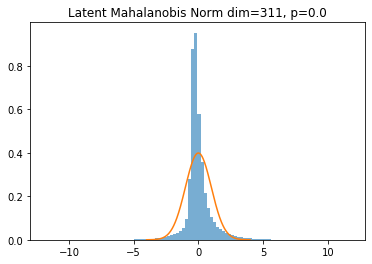

In [15]:
def single_marginal_latent_mahalanobis():
    marginals_dir = Path('marginals')
    marginals_dir.mkdir(exist_ok=True)
    dim_counter = 0
    
    with torch.no_grad():
        for i in tqdm(range(1024)):
            op = out_pos[:, i].to(device)
            m = mean[i]
#             cv = cov[i, i]
            
            fig, ax = plt.subplots()

            ax.hist(((op - m)/op.std()).cpu(), bins=100, density=True,
                     alpha=0.6)

#             print(stats.kstest(((op - m)/op.std()).cpu().flatten(), 'norm'))
            _, p = stats.kstest(((op - m)/op.std()).cpu().flatten(), 'norm')
            if p > 0:
                dim_counter += 1
#             print(stats.kstest(np.random.randn(20000), 'norm'))
#             print(((op - m)/op.std()).cpu().std())
#             print(stats.uniform(-1.7, 3.4).std())
            x = np.linspace(-4, 4, 1000)
#             print(stats.norm.pdf(x).shape)
#             print(stats.uniform.pdf(x, -1, 2).shape)
            e = 0.3
            conv = signal.convolve(stats.uniform.pdf(x, -1.7, 3.4), e*stats.norm.pdf(x/e), 'same')
            conv /= np.sum(e*stats.norm.pdf(x/e))
#             conv *= 8
            ax.plot(x, stats.norm.pdf(x), label='Normal Distribution')
#             ax.plot(x, conv)
#             ax.plot(x, stats.laplace.pdf(x, scale=0.5), label='Laplace Distribution')
            ax.set_title(f'Latent Mahalanobis Norm dim={i}, p={p}')
            fig.savefig(marginals_dir / f'{i:04d}.png')
            plt.close(fig)
            
    print(f'Number of dims: {dim_counter}')

cov = cov.detach()
mean = mean.detach()
single_marginal_latent_mahalanobis()

In [ ]:
print(np.linalg.matrix_rank(cov.cpu()))

In [ ]:
def investigate_degenerate_dim(d):
    typical = torch.distributions.multivariate_normal.MultivariateNormal(
                mean, cov
    )
    noise = typical.sample((1,)).repeat(10, 1)
    dim = torch.tensor(np.linspace(-200, 200, 10), device=device, dtype=torch.float)
    print(f'{mean[d]}+/-{torch.sqrt(cov[d, d])}')
    noise[:, d] = dim
    samples = model(noise, make_cond(2 * torch.ones(10, device=device).long()), rev=True)
    plt.figure(figsize=(15,1.5))
    plt.imshow(tensor2imgs(samples.reshape(-1, 1, 32, 32), 10).transpose(1, 2, 0))
    
    d = 0
    noise = typical.sample((1,)).repeat(10, 1)
    dim = torch.tensor(np.linspace(-200, 200, 10), device=device, dtype=torch.float)
    print(f'{mean[d]}+/-{torch.sqrt(cov[d, d])}')
    noise[:, d] = dim
    print(noise)
    samples = model(noise, make_cond(2 * torch.ones(10, device=device).long()), rev=True)
    plt.figure(figsize=(15,1.5))
    plt.imshow(tensor2imgs(samples.reshape(-1, 1, 32, 32), 10).transpose(1, 2, 0))
    
investigate_degenerate_dim(2)

In [ ]:
print(torch.sort(torch.abs(cov[2, :]), descending=True)[0][:100])
print(torch.sort(torch.abs(cov[2, :]), descending=True)[1][:100])

for i in range(1024):
    print(f"Dim {i}")
    print(torch.sort(torch.abs(cov[i, :]), descending=True)[0][:5])
    print(torch.sort(torch.abs(cov[i, :]), descending=True)[1][:5])
print(torch.abs(cov).min())

In [ ]:
def difference_marginal_latent_mahalanobis():
    
    with torch.no_grad():
        op0 = out_pos[:, 0].to(device)
        op1 = out_pos[:, 1].to(device)
        op2 = out_pos[:, 2].to(device)

        m0 = mean[0]
        m1 = mean[1]
        m2 = mean[2]
#             cv = cov[i, i]

        fig, ax = plt.subplots()

        ax.hist(np.random.normal(0, 1, 20000)*np.random.normal(0, 1, 20000), bins=100, density=True,
                 alpha=0.6)
        ax.hist(((op2 - m2)/op2.std()).cpu(), bins=100, density=True,
                     alpha=0.6)
#         ax.hist(((op2 - m2)/op2.std()).cpu(), bins=100, density=True,
#                      alpha=0.6)

#         _, p = stats.kstest(((op - m)/op.std()).cpu().flatten(), 'norm')

        x = np.linspace(-4, 4, 1000)

        ax.plot(x, stats.norm.pdf(x), label='Normal Distribution')
#             ax.plot(x, stats.laplace.pdf(x, scale=0.5), label='Laplace Distribution')
#         ax.set_title(f'Latent Mahalanobis Norm dim=0, p={p}')
        plt.show()
        plt.close(fig)
            
cov = cov.detach()
mean = mean.detach()
difference_marginal_latent_mahalanobis()

## Compare Typical with OOD Samples

### Samples from Class 0

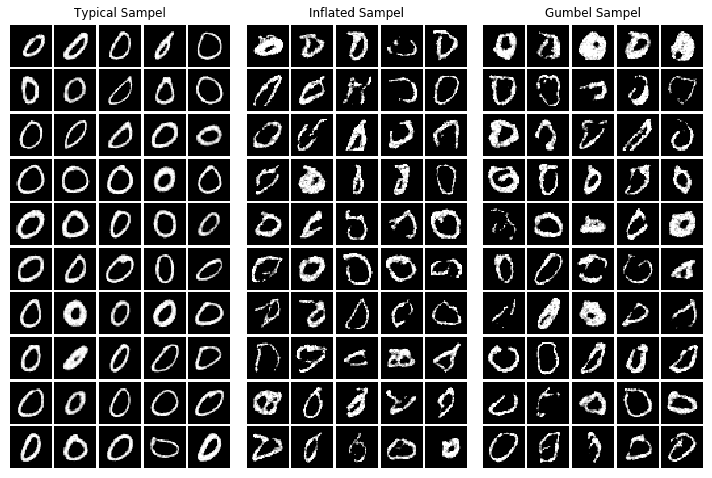

### Samples from Class 1

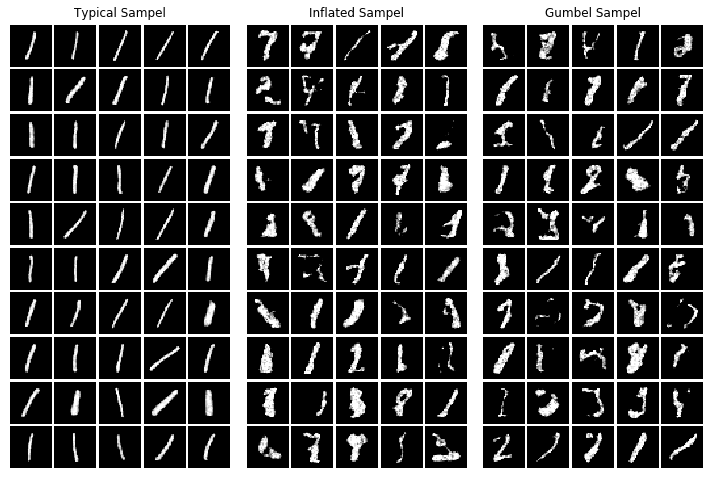

### Samples from Class 2

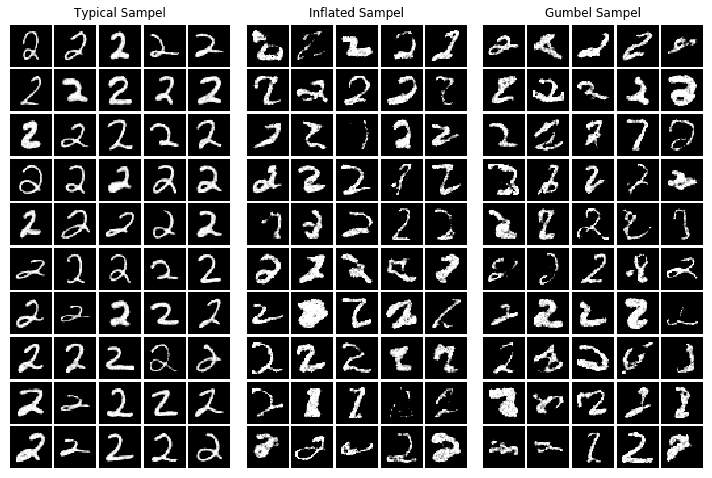

### Samples from Class 3

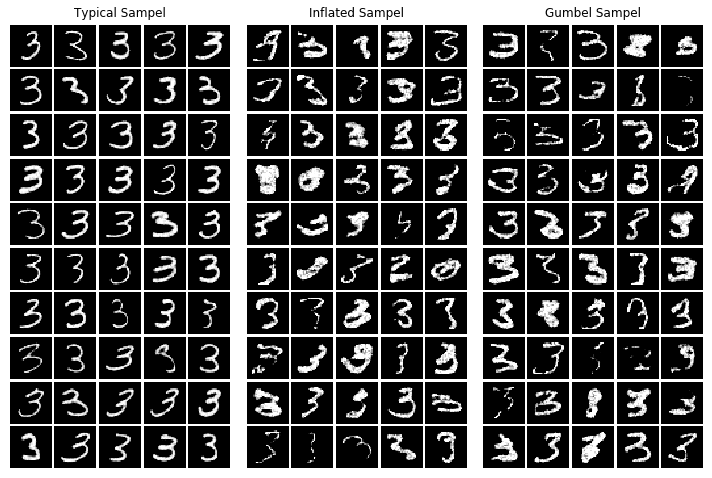

### Samples from Class 4

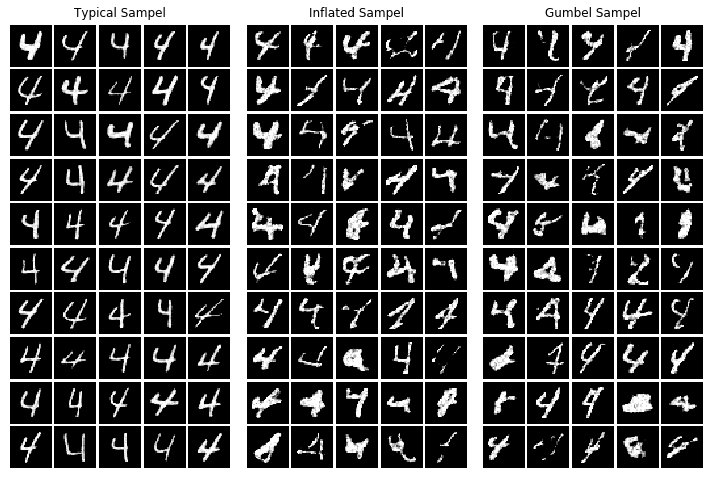

### Samples from Class 5

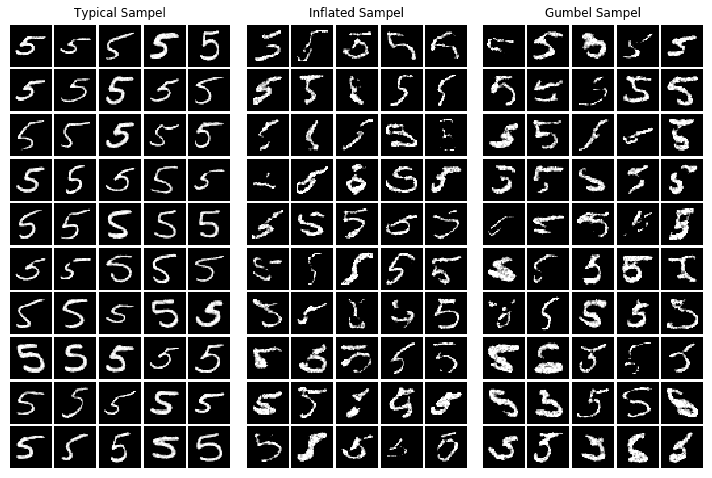

### Samples from Class 6

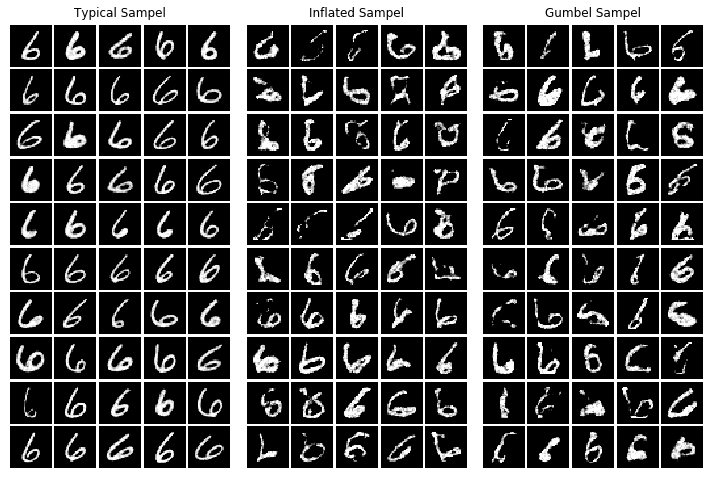

### Samples from Class 7

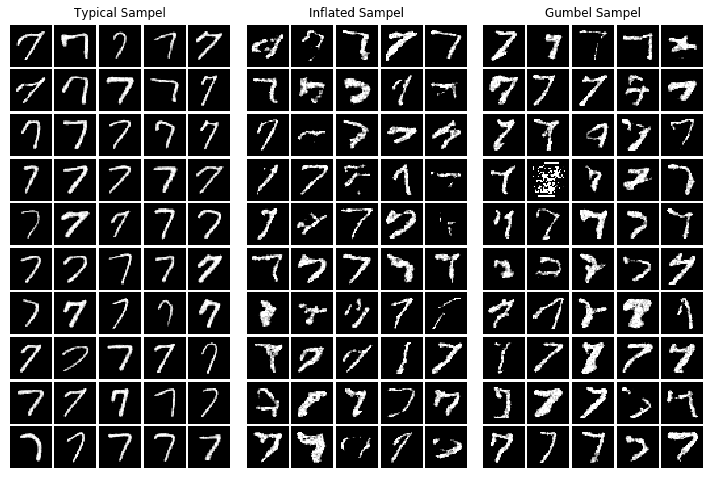

### Samples from Class 8

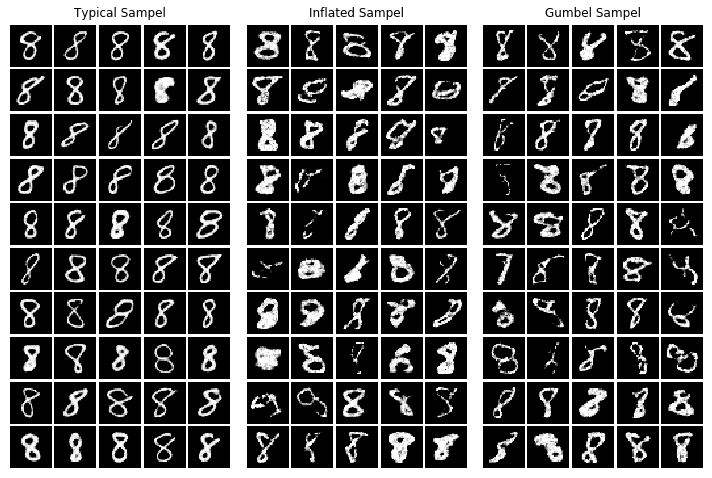

### Samples from Class 9

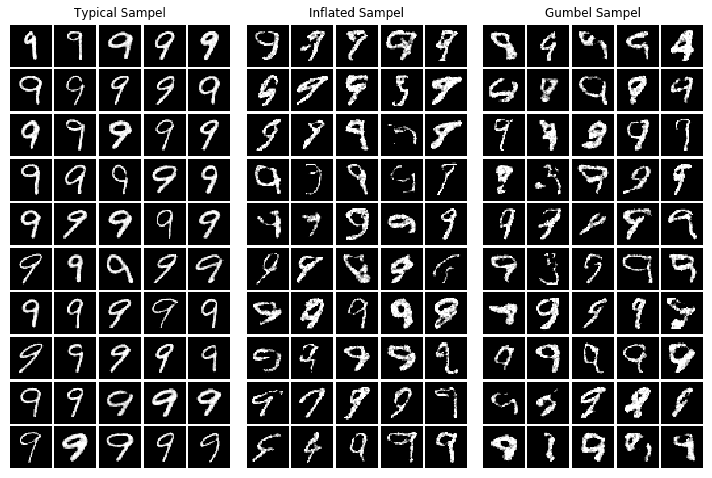

In [14]:
def compare_samples_all_classes():
    s = 3  # how many std's we go out for ood
    with torch.no_grad():
        
        inflated = torch.distributions.multivariate_normal.MultivariateNormal(
            mean, (s**2)*cov
        )
        
        std_normal = torch.distributions.multivariate_normal.MultivariateNormal(
            torch.zeros(32*32, device=device), torch.eye(32*32, device=device)
        )
        
        # chi(32*32).mean() ~= 32, chi(32*32).std() ~= 0.7
        # scipy won't directly calculate it and estimation from samples is noisy
        gumbel = torch.distributions.gumbel.Gumbel(
            32+b((s*32 - 32)**2)*0.7, 1/a((s*32 - 32)**2)*0.7
        )
        
        typical = torch.distributions.multivariate_normal.MultivariateNormal(
            mean, cov
        )
        
        def plot_samples(axis, noise, cl):
            samples = model(noise, make_cond(cl * torch.ones(50, device=device).long()), rev=True)
            confidence = torch.nn.functional.softmax(classifier(samples), dim=1)
            axis.imshow(tensor2imgs(samples.reshape(-1, 1, 32, 32), 5).transpose(1, 2, 0))
            axis.set_axis_off()
            
            return confidence

        def compare_samples(i):
            display_markdown(f'### Samples from Class {i}', raw=True)
            fig, axes = plt.subplots(1, 3, figsize=(10, 8), tight_layout=True, squeeze=True)

            plot_samples(axes[0], typical.sample((50,)), i)
            axes[0].set_title("Typical Sampel")
            
            plot_samples(axes[1], inflated.sample((50,)), i)
            axes[1].set_title("Inflated Sampel")


            # sample normalizes vectors uniformly from hypersphere
            noise = std_normal.sample((50,))
            noise /= torch.norm(noise, dim=1)[:, None]

            # sample mahalanobis radius and convert to euclidean
            r = gumbel.sample((50,))
            r_ = r[:, None, None] * (torch.sqrt(torch.diag(w[:, 0])) @ v.T)[None, :, :]
            
            # combine direction and radius
            noise = noise[:, None, :] @ r_
            noise = noise.reshape(-1, 32*32)
            noise += mean
            
            plot_samples(axes[2], noise, i)
            axes[2].set_title("Gumbel Sampel")

            plt.show()

        for i in range(10):
            compare_samples(i)
            
compare_samples_all_classes()

## Sample Quality with Increasing Sampling Distance

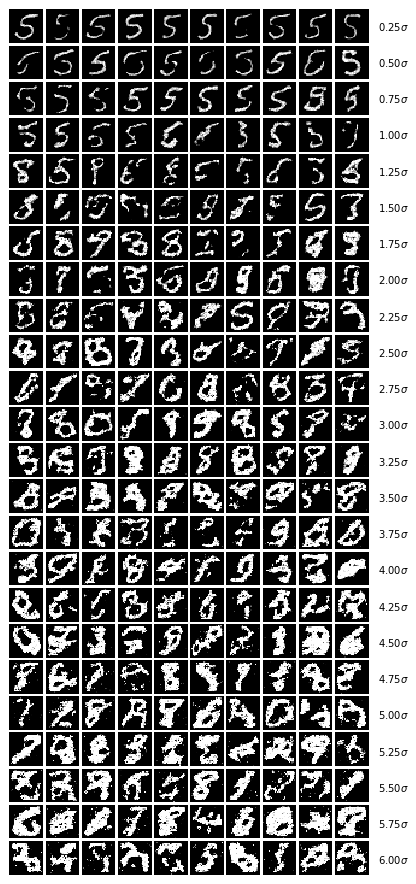

In [19]:
def sample_increasing_distance():
    with torch.no_grad():
        cl = 5
        
        w, v = torch.eig(torch.diag(model.log_sig[3]), eigenvectors=True)

        std_normal = torch.distributions.multivariate_normal.MultivariateNormal(
            torch.zeros(28*28, device=device), torch.eye(28*28, device=device)
        )

        samples = torch.empty(0, 1, 28, 28).to(device)

        plt.figure(figsize=(8,16))
        
        for l, i in enumerate(np.linspace(0.25, 1, 4)):
            typical = torch.distributions.multivariate_normal.MultivariateNormal(
                model.mu[cl], i*torch.diag(model.log_sig[cl])
            )

            samples = torch.cat([
                samples, 
                model(
                    typical.sample((10,)), 
                    make_cond(cl * torch.ones(10, device=device).long()),
                    rev=True
                )
            ])

            plt.text(1.02, 1 - (l+0.65)/24, f'{i:.2f}' + r'$\sigma$', transform=plt.gca().transAxes)

        for l, i in enumerate(np.linspace(1.25, 6, 20)):
            # chi(32*32).mean() ~= 32, chi(32*32).std() ~= 0.7
            # scipy won't directly calculate it and estimation from samples is noisy
            gumbel = torch.distributions.gumbel.Gumbel(
                28+b(((i - 1) * 28)**2)*0.7, 1/a(((i - 1) * 28)**2)*0.7
            )

            # sample normalizes vectors uniformly from hypersphere
            noise = std_normal.sample((10,))
            noise /= torch.norm(noise, dim=1)[:, None]

            # sample mahalanobis radius and convert to euclidean
            r = gumbel.sample((10,))
            r_ = r[:, None, None] * (torch.sqrt(torch.diag(w[:, 0])) @ v.T)[None, :, :]

            # combine direction and radius
            noise = noise[:, None, :] @ r_
            noise = noise.reshape(-1, 28*28)
            noise += model.mu[cl]

            samples = torch.cat([
                samples, 
                model(
                    noise, 
                    make_cond(cl * torch.ones(10, device=device).long()),
                    rev=True
                )
            ])

            plt.text(1.02, 1 - (l+0.65+4)/24, f'{i:.2f}' + r'$\sigma$', transform=plt.gca().transAxes)

        plt.axis('off')
        plt.imshow(tensor2imgs(samples.reshape(-1, 1, 28, 28)).transpose(1, 2, 0))
        plt.show()
        
sample_increasing_distance()

## Compare Radius of Gumbel and Inflated Sampling

In [ ]:
def compare_sample_statistics():
    s = 3  # how many std's we go out for ood
    with torch.no_grad():
        
        inflated = torch.distributions.multivariate_normal.MultivariateNormal(
            mean, (s**2)*cov
        )
        
        std_normal = torch.distributions.multivariate_normal.MultivariateNormal(
            torch.zeros(32*32, device=device), torch.eye(32*32, device=device)
        )
        
        # chi(32*32).mean() ~= 32, chi(32*32).std() ~= 0.7
        # scipy won't directly calculate it and estimation from samples is noisy
        gumbel = torch.distributions.gumbel.Gumbel(
            32+b((s*32 - 32)**2)*0.7, 1/a((s*32 - 32))*0.7
        )
        
        typical = torch.distributions.multivariate_normal.MultivariateNormal(
            mean, cov
        )
        
        x_ = np.linspace(0, 135, 1000)

        # sample normed vectors uniformly on hypersphere
        z = std_normal.sample((1000,))
        z /= torch.norm(z, dim=1)[:, None]
        
        # sample mahalanobis radius and convert to euclidean
        r = gumbel.sample((1000,)).to(device)
        r = r[:, None, None] * (torch.sqrt(torch.diag(w[:, 0])) @ v.T)[None, :, :]

        # combine direction and radius
        z = z[:, None, :] @ r
        z = z.reshape(-1, 1024)
        z += mean

        # sample from typical and inflated distribution
        y = inflated.sample((1000,))
        x = typical.sample((1000,))

        plt.figure(figsize=(12, 9))

        plt.hist(torch.norm(x, dim=1).cpu(), density=True, label='Typical norm', color='C0', alpha=0.6)
#         plt.hist(torch.norm(out_pos, dim=1), density=True, label='Training set norm', color='C8', alpha=0.6)
        plt.hist(
            torch.norm(z, dim=1).cpu(), density=True, label='Gumbel norm', alpha=0.6, color='C1'
        )

        plt.hist(torch.norm(y, dim=1).cpu(), density=True, label='Inflated norm', alpha=0.6, color='C2')

        plt.hist(
            torch.sqrt((x - mean)[:, None, :] @ icov @ (x - mean)[:, :, None]).reshape(-1).cpu(),
            density=True, label='Typical Mahalanobis', color='C3', alpha=0.6
        )
#         plt.hist(
#             dc,
#             density=True, label='Training Set Mahalanobis', color='C8', alpha=0.6, bins=150
#         )
        plt.plot(x_, stats.chi.pdf(x_, 1024), color='C3')

        plt.hist(
            torch.sqrt((y - mean)[:, None, :] @ icov @ (y - mean)[:, :, None]).reshape(-1).cpu(),
            density=True, label='Inflated Mahalanobis', color='C4', alpha=0.6
        )
        plt.plot(x_, stats.chi.pdf(x_, 1024, scale=s), color='C4')


        # plt.hist(np.sqrt(1/(s**2) * y[:, None, :] @ icov @ y[:, :, None]).reshape(-1), density=True, label='Inflated Mahalanobis corrected', alpha=0.6)
        plt.hist(torch.sqrt((z - mean)[:, None, :] @ icov @ (z - mean)[:, :, None]).reshape(-1).cpu(), density=True, label='Gumbel Mahalanobis', color='C7')

        plt.ylim((0, 1))
        plt.xlim((0, 135))
        plt.legend()
        plt.show()

compare_sample_statistics()

In [13]:
free_cuda_tensors()